In [ ]:
%%bash
mkdir $HOME/.keras
cp keras.json $HOME/.keras/.

In [2]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import hyperopt.fmin as hypfmin
import keras
import theano
import random
import os
import pickle
# from
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using cuDNN version 7005 on context None
Preallocating 11580/12189 Mb (0.950000) on cuda
Mapped name None to device cuda: TITAN X (Pascal) (0000:03:00.0)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
%%sh
watch nvidia-smi
#watch -n0.1 nvidia-smi

Process is interrupted.


In [19]:
keras.__version__

'1.2.2'

In [4]:
import os
from theano import function, config, shared, tensor
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<GpuArrayType<None>(float32, vector)>), HostFromGpu(gpuarray)(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.258791 seconds
Result is [1.2317803 1.6187935 1.5227807 ... 2.2077181 2.2996776 1.623233 ]
Used the gpu


In [5]:
theano.__version__

'1.0.1'

## Set plotting style

In [7]:
plt.rcParams["patch.force_edgecolor"] = True
sns.set_style('whitegrid',
              {'axes.grid': True,
               'grid.linestyle': u'--',
               'axes.edgecolor': '0.1',
               'axes.labelcolor': '0',
               'axes.labelsize': 15,
               'axes.titlesize': 15,
               'legend.fontsize': 15,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               })

In [8]:
ls

Notebook_1_CNN_Model_Training_with_Hyperparameter_Search.ipynb
Notebook_2_CNN_Predictions_of_Random_UTR_HIS3_data.ipynb
Notebook_3_CNN_Predictions_of_Native_UTR_HIS3_data.ipynb
Notebook_4_Generating_Model_Directed_Evolution_of_UTRs_From_100_Native_and_Random_UTRs.ipynb


## Check if the various directories that you might care about in the future are present

In [9]:
data_dir = '../Data/'
results_dir = '../Results/'
figures_dir = '../Figures/'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)

## Create a directory to save the model parameters:

In [10]:
model_name = 'Random_UTR_CNN'
model_params_dir = '../Results/{0}.Hyperparam.Opt/'.format(model_name)

if not os.path.exists(model_params_dir):
    os.mkdir(model_params_dir)

In [11]:
%%sh
ls ../Results/

ls ../..


EvolvedUTRs
Random_UTR_CNN.Hyperparam.Opt
Random_UTR_CNN_Hyperparams.tar.gz
161222_ip_ugi_band_PSMs.txt
170523_1_EColi_170524165739-(2)_PeptideGroups.txt
170523_1_EColi_170524165739-(2)_ProteinGroups.txt
170523_1_EColi_170524165739-(2)_Proteins.txt
170523_1_EColi_170524165739-(2)_ResultStatistics.txt
2017---Deep-learning-yeast-UTRs
aifMsms.txt
allPeptides.txt
check.txt
CMakeLists.txt
Combo.txt
Comet-chunk.ipynb
Comet.ipynb
CoMMpass_IA8b.txt
CoMMpass_IA8b.txtcoxPHsortNoLog2.txt
CoMMpass_IA8b.txtcoxPHsort.txt
CoMMpass_IA8b.txtcoxPH.txt
Compass_Survival_per.txt
Compass_Survival.txt
Copy of 170214 total proteome lymphom 0p05 SILAC pluss LFQ (2).txt
Copy of Strainssamples_shuffled_final_150617.txt
Copy of SuperSILACpTtestImp.txt
Copy of toptags_DE5 (2).txt
Copy of toptags_DE5 (3).txt
Deamidation (NQ)Sites.txt
ECCO 2017 Breath Test.txt
EcoliMascotLog2SSttestPB.txt
Elasticsearch.ipynb
evidence.txt
fastakey.txt
GroupsMascot.txt
Groups.txt
keras.json
Keyfile_pegfam_annot.txt
LFQttestPBs0p10.txt

## Load our cleaned up data.

The csv should be tab-separated. The read counts are log2.

In [12]:
data = pd.read_csv(data_dir + 'Random_UTRs.csv.gz')

In [13]:
data

,Unnamed: 0,UTR,growth_rate,t0,t1
0,0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,14,3
1,1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,14,49
2,2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,13,6
3,3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,12,3
4,4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,7,6
5,5,AAAAAAAAACGAAATCAAACAAGAGAAAAACTGCATAGTTCACTTA...,0.822290,10,22
6,6,AAAAAAAAACGAATGAACGAGTAACAAAGGACCCCTAATAACTCGA...,-1.013922,2,0
7,7,AAAAAAAAACGGCAAACATAAGTAAGCGCTAAAACCTTTTATTGAA...,-0.104551,28,23
8,8,AAAAAAAAACGTTGCTATTATACCGAAGTCGCCCTAAAGCGTCCCT...,0.994061,57,143
9,9,AAAAAAAAACTAATTCTGGAGCGACAAGTTTATACCCCATATTTTC...,-0.113760,49,40


## One-hot encoding of the sequences.

i.e. we're converting the sequences from being represented as a 50 character string of bases to a 4x50 matrix of 1's and 0's, with each row corresponding to a base and every column a position in the UTR.

In [14]:
# one hot encoding of UTRs
# X = one hot encoding matrix
# Y = growth rates

def one_hot_encoding(df, seq_column, expression):
    
    bases = ['A','C','G','T']
    base_dict = dict(zip(bases,range(4))) # {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    n = len(df)
    
    # length of the UTR sequence
    # we also add 10 empty spaces to either side
    total_width = df[seq_column].str.len().max() + 20
    
    # initialize an empty numpy ndarray of the appropriate size
    X = np.zeros((n, 1, 4, total_width))
    
    # an array with the sequences that we will one-hot encode
    seqs = df[seq_column].values
    
    # loop through the array of sequences to create an array that keras will actually read
    for i in range(n):
        seq = seqs[i]
        
        # loop through each individual sequence, from the 5' to 3' end
        for b in range(len(seq)):
            # this will assign a 1 to the appropriate base and position for this UTR sequence
            X[i, 0, base_dict[seq[b]], int(b + round((total_width - len(seq))/2.))] = 1.
    
        # keep track of where we are
        if (i%10000)==0:
            print(i),
        
    X = X.astype(theano.config.floatX)
    Y = np.asarray(df[expression].values,
                   dtype = theano.config.floatX)[:, np.newaxis]
    
    return X, Y, total_width

In [15]:
X, Y, total_width = one_hot_encoding(data, 'UTR', 'growth_rate')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000


## Split the data into test and training sets

If we have more reads for a given UTR at the outset, we can be more confident that we have made an accurate measurement. For this reason, we use those UTRs with the most reads to test our model on, because these should have the least experimental noise. We hold out the UTRs that fall in top 5% of reads at the first time point as our test set.

In [21]:
# a sorted numpy array of UTR indexes, from least reads to most reads
sorted_inds = data.sort_values('t0').index.values


train_inds = sorted_inds[:int(0.95*len(sorted_inds))] # 95% of the data as the training set


test_inds = sorted_inds[int(0.95*len(sorted_inds)):] # UTRs with most reads at time point 0 as the test set

# set the seed before randomly shuffling the data
seed = 0.5
random.shuffle(train_inds, lambda :seed)

## Hyperparameter search

Before training the model, we perform a hyperparameter search to narrow down which model architecture to use. Of course, we do a fair amount of narrowing ourselves by selecting which architectures are available for the search.

The dictionary 'hyperparams' has the same values as the 'space' object, 'space' is just the form that's compatible with hyperopt.

In [22]:
hyperparams = {'conv_width' : [9, 13, 17, 25],
               'conv_filters' : [32, 64, 128, 256],
               'conv_layers' : [2, 3, 4],
               'dense_layers' : [1, 2],
               'conv_dropout' : [None, 0.15],
               'dense_dropout' : [None, 0.1, 0.25, 0.5],
               'dense_units' : [32, 64, 128, 256]}

In [23]:
space = {   'conv_width': hp.choice('conv_width', [9, 13, 17, 25]),
            'conv_filters': hp.choice('conv_filters', [32, 64, 128, 256]),
            'conv_layers': hp.choice('conv_layers', [2, 3, 4]),
            'dense_layers': hp.choice('dense_layers', [1, 2]),
            'conv_dropout': hp.choice('conv_dropout',  [None, 0.15]),
            'dense_dropout': hp.choice('dense_dropout', [None, 0.1, 0.25, 0.5]),
            'dense_units': hp.choice('dense_units', [32, 64, 128, 256]),
        }

#### Defining a function to build the model

- Note: we reuse this same function lower down after we've decide on a model architecture 

In [24]:
def create_model(params):
    model = Sequential()
    model.add(Convolution2D(params['conv_filters'],
                            4,
                            params['conv_width'],
                            border_mode = 'valid',
                            input_shape = (1, 4, total_width),
                            activation = 'relu'))
    
    # add dropout at the convolutional layers if appropriate
    if params['conv_dropout']:
        model.add(Dropout(p = params['conv_dropout']))
    
    # add the appropriate number of additional convolutional layers, along with dropout
    for i in range(params['conv_layers'] - 1):
        model.add(Convolution2D(params['conv_filters'],
                                1,
                                params['conv_width'],
                                border_mode = 'same',
                                activation = 'relu'))
        
        if params['conv_dropout']:
            model.add(Dropout(params['conv_dropout']))
    
    model.add(Flatten())
    
    # add the appropriate number of dense layers and dropout
    for i in range(params['dense_layers']):
        model.add(Dense(output_dim = params['dense_units'],
                        activation = 'relu'))
        
        if params['dense_dropout']:
            model.add(Dropout(p = params['dense_dropout']))
    
    # add the output layer, since we want to predict the "growth rate" we only want a single 
    # number, hence the single dimension
    model.add(Dense(output_dim = 1))
    
    # compile the model
    model.compile(loss = 'mean_squared_error',
                  optimizer = 'adam',
                  metrics = ['mean_squared_error'])
    
    return model

#### We also need a function that builds and fits the model, which we can pass to the hyperparameter search.

- It also returns some information regarding overfitting, etc.
- note that the data is included inside the function, I'm not passing it to the function.

In [25]:
def f_nn(params):
    
    model = create_model(params)
    
    # track model overfitting
    earlyStopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 1,
                                                  verbose = 0,
                                                  mode = 'auto')
    history = keras.callbacks.History()
    
    # keep track of where we are while the code in this cell is running
    global n
    print("\n"), n
    n+=1
    print(params)
    
    # fit the model
    # note that I'm not passing the data to this function, I've just included it here (i.e. I've
    # included X and Y)
    model.fit(X[train_inds],
              Y[train_inds],
              validation_split = 0.2,
              callbacks = [earlyStopping, history],
              verbose = 0,
              nb_epoch = 100)
    
    print('MSE:',earlyStopping.best)
    return {'loss': earlyStopping.best, 'status': STATUS_OK}

#### Actually perform the hyperparameter search.

A note here, there're random elements in keras and hypfmin that I don't understand how to control, so I haven't been able to set a seed that will allow you to obtain exactly the same results for the hyperparameter search that we have.

In [65]:
from keras import backend as K
K.set_image_dim_ordering('th')
n = 0

trials = Trials()
best = hypfmin(f_nn, space,algo = tpe.suggest,max_evals = 5,trials = trials)

print('best: ',best)




{'conv_dropout': None, 'conv_filters': 64, 'conv_layers': 3, 'conv_width': 9, 'dense_dropout': None, 'dense_layers': 2, 'dense_units': 256}
MSE: 0.5931184581144195


{'conv_dropout': 0.15, 'conv_filters': 64, 'conv_layers': 2, 'conv_width': 9, 'dense_dropout': 0.1, 'dense_layers': 2, 'dense_units': 32}
MSE: 0.6086380608088793


{'conv_dropout': 0.15, 'conv_filters': 256, 'conv_layers': 2, 'conv_width': 25, 'dense_dropout': 0.5, 'dense_layers': 2, 'dense_units': 64}
MSE: 0.9965437406456382


{'conv_dropout': None, 'conv_filters': 128, 'conv_layers': 2, 'conv_width': 9, 'dense_dropout': None, 'dense_layers': 1, 'dense_units': 32}
MSE: 0.6137590202462999


{'conv_dropout': 0.15, 'conv_filters': 32, 'conv_layers': 4, 'conv_width': 13, 'dense_dropout': 0.25, 'dense_layers': 1, 'dense_units': 128}
MSE: 0.6053521354562381
best:  {'conv_dropout': 0, 'conv_filters': 1, 'conv_layers': 1, 'conv_width': 0, 'dense_dropout': 0, 'dense_layers': 1, 'dense_units': 3}


pickle the model

In [38]:
with open(model_params_dir + 'hyperparam_test.pkl', 'wb') as f:
    pickle.dump(trials.trials, f)

and take a look a the winning architecture

In [39]:
opt_params = {}

for p in best:
    opt_params[p] = hyperparams[p][best[p]]

In [40]:
opt_params

{'conv_dropout': 0.15,
 'conv_filters': 128,
 'conv_layers': 3,
 'conv_width': 17,
 'dense_dropout': None,
 'dense_layers': 1,
 'dense_units': 128}

## Create and train the convolutional neural network

In [41]:
model = create_model(opt_params)

In [42]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience = 0,
                                              verbose = 0,
                                              mode = 'auto')

history = keras.callbacks.History()

modelcheckpoint = keras.callbacks.ModelCheckpoint(model_params_dir + 'model_weights.hdf5',
                                                  monitor = 'val_loss',
                                                  verbose = 0,
                                                  save_best_only = True,
                                                  mode = 'auto')

In [43]:
model.fit(X[train_inds],
          Y[train_inds],
          validation_split = 0.1,
          callbacks = [earlyStopping,
                       history,
                       modelcheckpoint],
          verbose=1,
          nb_epoch = 100)

Train on 418392 samples, validate on 46488 samples
Epoch 1/100
418392/418392 [==============================] - 41s - loss: 0.8189 - mean_squared_error: 0.8189 - val_loss: 0.6075 - val_mean_squared_error: 0.6075
Epoch 2/100
418392/418392 [==============================] - 41s - loss: 0.7546 - mean_squared_error: 0.7546 - val_loss: 0.6099 - val_mean_squared_error: 0.6099


#### Save the model

In [44]:
json_string = model.to_json()
open(model_params_dir + 'model_arch.json', 'w').write(json_string)
model.save_weights(model_params_dir + 'model_weightsN.h5')

## Use the model to predict the growth rates from our library of 5' UTR sequences

- we do this on the entire library because we want to compare the fits of the test and training data.
    - you would generally expect to maybe do a little better on the training data. However, since we use the highest quality data for our test set -- the values that we're most confident about -- it's not maybe not that surprising that our predictions are more accurate on our test set (see results two cells down).

In [45]:
Y_pred = model.predict(X,verbose=1)

488320/489348 [============================>.] - ETA: 0s

In [56]:
# R^2 value for our predictions on the training set
print(scipy.stats.pearsonr(Y[train_inds].flatten(),Y_pred[train_inds].flatten())[0]**2)
# and on the test set
print(scipy.stats.pearsonr(Y[test_inds].flatten(),Y_pred[test_inds].flatten())[0]**2)

0.4660663204465578
0.6038322975433061


## Make sure the model architecture and parameters are saved correctly

In [57]:
!ls {model_params_dir}

hyperparam_test.pkl  model_weights.h5	 model_weightsN.h5
model_arch.json      model_weights.hdf5


In [58]:
model = keras.models.model_from_json(open(model_params_dir + 'model_arch.json').read())
model.load_weights(model_params_dir + 'model_weights.hdf5')
model.compile(loss='mean_squared_error', optimizer='adam')

In [59]:
Y_pred = model.predict(X, verbose=1)

489348/489348 [==============================] - 17s    


In [66]:
# R^2 value for our predictions on the training set
print(scipy.stats.pearsonr(Y[train_inds].flatten(),
                           Y_pred[train_inds].flatten())[0]**2)

# and on the test set
print(scipy.stats.pearsonr(Y[test_inds].flatten(),
                           Y_pred[test_inds].flatten())[0]**2)

0.45515014748617943
0.5949599898707483


## Plot results

Text(-3,1.25,'CNN predictions vs. test set')

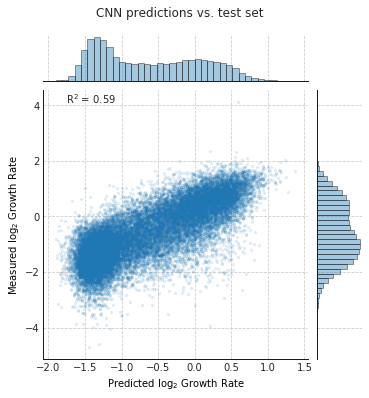

In [62]:
# data
x = Y_pred[test_inds].flatten()
y = Y[test_inds].flatten()

# calculate R^2
r2 = scipy.stats.pearsonr(x, y)[0]**2


g = sns.jointplot(x,
                  y,
                  stat_func = None,
                  kind = 'scatter',
                  s = 5,
                  alpha = 0.1,
                  size = 5)

g.ax_joint.set_xlabel('Predicted log$_2$ Growth Rate')
g.ax_joint.set_ylabel('Measured log$_2$ Growth Rate')



text = "R$^2$ = {:0.2}".format(r2)
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')

plt.title("CNN predictions vs. test set", x = -3, y = 1.25)

## Save data and predictions to csv

In [63]:
data['pred_growth_rate'] = Y_pred

In [64]:
data.to_csv(data_dir + 'Random_UTRs_with_predictionsN.csv')